# Read and Explore Data

In [1]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from typing import Union, Tuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [1]:
from task1.retrieval_system import RetrievalSystem, SongInfo
from task1.similarity_measure import (
    cosine_similarity,
    dot_product,
    manhattan_distance,
    euclidean_distance,
    random_similarity,
)
from utils import read, embed_and_merge

ModuleNotFoundError: No module named 'task1'

In [3]:
# basic song information from task 1
df = read("information", 0)
df

,id,artist,song,album_name
0,01Yfj2T3YTwJ1Yfy,We As Human,Take The Bullets Away (feat. Lacey Sturm),We As Human
1,01gyRHLquwXDlhkO,The Notorious B.I.G.,Somebody's Gotta Die,Life After Death (Remastered Edition)
2,01rMxQv6vhyE1oQX,Against the Current,Chasing Ghosts,In Our Bones
3,02RGE9FNH65RtMS7,Barthezz,Infected,Trance - The Early Years (1997-2002)
4,02ZnlCGZEbkfCDxo,Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te
...,...,...,...,...
10090,zyzILCQvVeUFIINi,Crowded House,When You Come,Temple Of Low Men
10091,zzgS4ZqyswamEWNj,Britney Spears,My Only Wish (This Year),Platinum Christmas
10092,zzoFYDMlqU1X2zz1,Thundercat,DUI,Drunk
10093,zzpkRCGA5ud8q4mv,Otis Redding,Rock Me Baby,Otis Blue


In [4]:
# add genre information for metric calculation
genres = read("genres", 0)
# convert genre to actual list via eval
genres["genre"] = genres["genre"].apply(eval).apply(set)
df = df.merge(genres, on="id", how="left")

We load one new feature and the features from the previous assignments. We need them for comparison and fusion.

In [5]:
visual_feature = "resnet"
stats = read(visual_feature, 0)
df = embed_and_merge(df, stats, visual_feature)

for audio_feature in ["mfcc_bow", "blf_spectral", "ivec256", "musicnn"]:
    stats = read(audio_feature, 0)
    df = embed_and_merge(df, stats, audio_feature)

for text_feature in ["lyrics_bert", "lyrics_word2vec", "lyrics_tf-idf"]:
    stats = read(text_feature, 0)
    df = embed_and_merge(df, stats, text_feature.split("_")[1])

In [6]:
df.isna().sum()

id              0
artist          0
song            0
album_name      0
genre           1
resnet          1
mfcc_bow        1
blf_spectral    1
ivec256         1
musicnn         1
bert            0
word2vec        0
tf-idf          0
dtype: int64

In [7]:
# data for task 2 and task 3 does not include the item with id "03Oc9WeMEmyLLQbj" = row 5
df = df.drop(5)
df = df.reset_index()

# Define retrieval systems

## From Task 1 (text-based)

In [8]:
rs_random = RetrievalSystem(
    df=df,
    sim_metric=random_similarity,
)

In [9]:
rs_cos_tdidf = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="tf-idf",
)

In [10]:
rs_cos_bert = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="bert",
)

In [11]:
rs_dot_w2v = RetrievalSystem(
    df=df,
    sim_metric=dot_product,
    sim_feature="word2vec",
)

## From Task 2 (audio-based)

In [12]:
rs_cos_mfcc = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="mfcc_bow",
)

In [13]:
rs_cos_blf = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="blf_spectral",
)

In [14]:
rs_cos_ivec256 = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="ivec256",
)

In [15]:
rs_cos_dnn = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="musicnn",
)

## From Task 3 (video-based; new!)


In [16]:
rs_cos_resnet = RetrievalSystem(
    df=df,
    sim_metric=cosine_similarity,
    sim_feature="resnet",
)

## Fusion Techniques

### Early Fusion
In this section we will perform early fusion of 2 features by:
- Concatenating two features
- Pre-processing the features
- Defining a retrieval system on the aggregated feature


In [17]:
def scale_feature(feature):
    arr=[]
    for row in feature:
        arr.append(row)
    arr =  np.array(arr)

    # fir scaler to whole feature
    scaler = StandardScaler()
    scaler.fit(arr)

    for idx, row in tqdm(enumerate(feature), total=len(feature), desc="Scaling rows"):
        # scale row
        transformed_row = scaler.transform(row.reshape(1, -1))
        # Update the copy of the column
        feature.iloc[idx] = transformed_row[0]
    return feature

In [18]:
def concat_scale_features(first_feature, second_feature, df):
    # Concat features to form aggregated feature
    first = df[first_feature]
    second = df[second_feature]

    # no scaling yields better results
    # first = scale_feature(first.copy())
    # second = scale_feature(second.copy())

    combined_features = pd.concat([first, second], axis=1)
    combined_features['aggr_feature'] = combined_features.apply(lambda row: np.concatenate(row), axis=1)

    print(f"Number of columns in the first feature: {len(combined_features.iloc[0, 0])}")
    print(f"Number of columns in the second feature: {len(combined_features.iloc[0, 1])}")
    print(f"Number of columns in the combined features: {len(combined_features.iloc[0, 2])}")

    # returns dataframe with first, second and combined feature
    return combined_features

In [19]:
def pca_feature(combined_features):
    # reduce columns to 20%
    pca_components = int(len(combined_features.iloc[0, 2])*0.2)
    print(f"Reducing aggregated feature to {pca_components} components")
    pca = PCA(n_components=pca_components)
    arr= []

    # convert to arr where feature values are columns and rows are samples
    for row in combined_features["aggr_feature"]:
        arr.append(row)
    arr =  np.array(arr)

    # fit pca to whole whole arr
    pca.fit(arr)

    aggr_feature_copy = combined_features["aggr_feature"].copy()

    for idx, row in tqdm(enumerate(aggr_feature_copy), total=len(aggr_feature_copy), desc="Transforming rows"):
        transformed_row = pca.transform(row.reshape(1, -1))
        aggr_feature_copy.iloc[idx] = transformed_row[0]

    # returns dataframe containing only the reduced feature
    return aggr_feature_copy

In [20]:
def early_fusion(first_feature, second_feature, df):
    # concat (no scaling as it decreases precision)
    features = concat_scale_features(first_feature, second_feature, df)
    # reduce dimensionality
    aggr_feature = pca_feature(features)
    name = f"ef_{first_feature}_{second_feature}"
    # Add aggregated feature to the dataframe
    df[name] = aggr_feature

    # And define new retrieval system instance for aggregated feature
    new_rs = RetrievalSystem(
        df=df,
        sim_metric=cosine_similarity,
        sim_feature=name,
    )
    # returns retrieval system instance with early fusion
    return new_rs, name, df


In [21]:
# define new RS
rs_cos_early_fusion_1, feature_name1, df = early_fusion("bert", "musicnn", df)

Number of columns in the first feature: 768
Number of columns in the second feature: 50
Number of columns in the combined features: 818
Reducing aggregated feature to 163 components


Transforming rows:   0%|          | 0/10094 [00:00<?, ?it/s]

In [22]:
df.columns

Index(['index', 'id', 'artist', 'song', 'album_name', 'genre', 'resnet',
       'mfcc_bow', 'blf_spectral', 'ivec256', 'musicnn', 'bert', 'word2vec',
       'tf-idf', 'ef_bert_musicnn'],
      dtype='object')

In [23]:
df["ef_bert_musicnn"][0].shape

(163,)

### Late Fusion
In this section we will perform late fusion of 2 retrieval systems using the borda count rank aggregation method by:
- precomputing all retrievals and their similarities for chosen retrieval systems.
- Assigning ranks to the similarity scores
- Add up ranks, the 400 top items of each system are considered
- fusing systems via borda rank aggregation

In [24]:
def pre_compute_retrievals(first_rs, second_rs, items, df):
    # pre compute retrievals
    res = []

    for system in tqdm([first_rs, second_rs], desc="Precomputing systems"):
        sim_matrix = df[["id", "song", "artist"]].copy()
        sim_matrix["id_n"] = None
        sim_matrix["song_n"] = None
        sim_matrix["artist_n"] = None
        sim_matrix["sim_n"] = None
        sim_matrix["genre"] = None

        for idx, song_id in tqdm(enumerate(df["id"]), total=len(df["id"]), desc=f"Retrieving songs"):
            sim = system.retrieve(song_id, items)
            # save relevant information for top_n returns
            sim_matrix.at[idx, "id_n"] = sim["id"]
            sim_matrix.at[idx, "song_n"] = sim["song"]
            sim_matrix.at[idx, "artist_n"] = sim["artist"]
            # assign ranks, higher sim = higher rank
            sim_matrix.at[idx, "sim_n"] = sim["similarity"].rank()
            sim_matrix.at[idx, "genre"] = sim["genre"]

        res.append(sim_matrix)
        
    # returns list with 2 dataframes containing top_n retrievals for each song
    
    return res

In [25]:
def precompute_ranks(res, df, items, n):
    all_ranks = pd.DataFrame(columns=["id", "top_n"])
    for idx, song_id in tqdm(enumerate(df["id"]), total=len(df["id"]), desc=f"Precomputing ranks"):
        system_one = res[0].loc[res[0]['id'] == song_id]
        system_two = res[1].loc[res[1]['id'] == song_id]
        merge = pd.concat([system_one, system_two], ignore_index=True)

        top_n = pd.DataFrame(columns=["id", "song", "artist", "genre", "similarity"])
        score_dict = {}
        for n_id, n_song, n_artist, n_genre, n_scores in zip(merge["id_n"],
                                                    merge["song_n"],
                                                    merge["artist_n"],
                                                    merge["genre"],
                                                    merge["sim_n"]):
            for track_id, track, artist, genre, score in zip(n_id,
                                                      n_song,
                                                      n_artist,
                                                      n_genre,
                                                      n_scores):

                if track_id not in score_dict.keys():
                    score_dict[track_id] = score
                    new_row = {"id": track_id, 'song': track, 'artist': artist, "genre": genre, 'similarity': score}
                    top_n.loc[len(top_n)] = new_row
                else:
                    # borda rank aggregation, add up ranks
                    score_dict[track_id] += score
                    # score_dict[track_id] /= 2
                    top_n.loc[top_n["id"] == track_id, "similarity"] = score_dict[track_id]


        top_n = top_n.sort_values(by="similarity", ascending=False)
        top_n = top_n.iloc[:n]
        top_n["similarity"] /= items*2
        new_row = pd.DataFrame({'id': [song_id], 'top_n': [top_n]})

        all_ranks = pd.concat([all_ranks, new_row], ignore_index =True)

    # returns a dataframe which holds top_n ranks for all songs
    return all_ranks

In [26]:
def check_stat(res):
    # check compatability of top-n scores
    for i, sim_ma in enumerate(["first_rs", "second_rs"]):
        arr = []
        for row in res[i]["sim_n"]:
            arr.append(row)
        arr =  np.array(arr)
        print(f"\nStatistics for scores of {str(sim_ma)}:")
        print(f"  Mean: {arr.mean().mean()}")
        print(f"  Standard Deviation: {arr.std().mean()}")




By extending the RS class and overriding the retrieve method, we can utilize the testing pipeline from task2 for late fusion

In [27]:
# late fusion/ retrieval system
class LateFusion(RetrievalSystem):
    def __init__(self, first_rs: RetrievalSystem, second_rs: RetrievalSystem, df: pd.DataFrame):
        super().__init__(df)
        # how many items are retrieved for each song, thus considered in the borda rank
        self.items_to_consider = 400
        self.res = pre_compute_retrievals(first_rs, second_rs, self.items_to_consider, self.df)
        check_stat(self.res)
        # n should be at least 100 for the precison and recall curves
        self.ranks = precompute_ranks(self.res, self.df, self.items_to_consider, n=100)
    def retrieve(self, query,  n: int = 10):
        # retrieval process of song like in class rs
        if isinstance(query, (int, str)):
            song_id = query
            if song_id not in self.df["id"].values:
                raise ValueError(f"Song id {song_id} not in the dataset.")
            song = (self.df.loc[song_id]
                if isinstance(song_id, int)
                else self.df[self.df["id"] == song_id].iloc[0]
            )
        elif isinstance(query, SongInfo):
            title, artist = query.title, query.artist
            song = self.df[(self.df["song"] == title) & (self.df["artist"] == artist)]
            if song.empty:
                raise ValueError(
                    f"Song with title '{title}' and artist '{artist}' not found in the dataset."
                )
            song = song.iloc[0]
        else:
            raise ValueError(
                "Invalid query type. Provide either song_id (int/str) or an instance of SongInfo."
            )

        # Find the index of the row with the specified ID in all_ranks
        idx = self.ranks[self.ranks['id'] == song["id"]].index.item()

        selected_top_n = self.ranks.at[idx, 'top_n']

        return selected_top_n[:n]


In [28]:
# Create new instance of late fusion RS
late_fusion_cnn_bert = LateFusion(first_rs=rs_cos_dnn,
                         second_rs=rs_cos_bert,
                         df=df)


Precomputing systems:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving songs:   0%|          | 0/10094 [00:00<?, ?it/s]

Retrieving songs:   0%|          | 0/10094 [00:00<?, ?it/s]


Statistics for scores of first_rs:
  Mean: 200.5
  Standard Deviation: 115.46969008333893

Statistics for scores of second_rs:
  Mean: 200.5
  Standard Deviation: 115.46968896637799


Precomputing ranks:   0%|          | 0/10094 [00:00<?, ?it/s]

In [29]:
sample_song = SongInfo(title="Always", artist="Bon Jovi")
late_fusion_cnn_bert.retrieve(sample_song)

,id,song,artist,genre,similarity
5,MBvrRnbK5666FPvz,Live With Me,Massive Attack,"{electro, pop, downtempo, experimental, ambien...",0.89125
52,8cM4LdET14KP9vSR,Cold Dark Place,Mastodon,{ambient},0.86625
29,qa1KIMkpu8LlS1Mo,Don't Forget About Me,Dusty Springfield,"{british invasion, pop, easy listening, baroqu...",0.85375
115,PBGBniDXOl8JRekW,Es Por Tí,Juanes,"{latin rock, rock en espanol, pop, spanish roc...",0.79000
129,ZsDuTbSasoyF0wN8,Digitais,Isabella Taviani,"{mpb, pop, nova mpb}",0.71500
59,sqnkDpNrmNYok0Og,Beautiful,The Smashing Pumpkins,"{sleep, dream pop, progressive rock, krautrock...",0.66375
340,RvExtv1mIVglWrLc,Gone So Young,Amber Pacific,"{sleep, alternative rock, metal, indie rock, s...",0.57000
32,lRK06n1HkuHlVdRo,Mi Vida Sin Tu Amor,Cristian Castro,"{latin, pop, latin pop, pop romantico}",0.50500
19,aWfi2aT3k20nSgkp,Lo Hare Por Ti,Paulina Rubio,"{mexican pop, pop, latin pop, pop rock, latin}",0.50125
400,g5Y3fz7C9EnMXdMA,Blue Jeans (Gesaffelstein Remix),Lana Del Rey,"{electro, pop, alternative pop}",0.50000


## Combine all systems

In [30]:
# create pd dataframe consisting of all retrieval systems, with metric and feature
rs = pd.DataFrame(
    [
        ["random", "random", rs_random],
        ["cosine", "tf-idf", rs_cos_tdidf],
        ["cosine", "bert", rs_cos_bert],
        ["dot", "word2vec", rs_dot_w2v],
        ["cosine", "mfcc_bow", rs_cos_mfcc],
        ["cosine", "blf_spectral", rs_cos_blf],
        ["cosine", "ivec256", rs_cos_ivec256],
        ["cosine", "musicnn", rs_cos_dnn],
        ["cosine", "resnet", rs_cos_resnet],
        ["cosine", feature_name1, rs_cos_early_fusion_1],
        ["borda count", "late_fusion", late_fusion_cnn_bert],

    ],
    columns=["metric", "feature", "rs_object"],
)

# Evaluation

In [31]:
from pipeline import Pipeline

evaluate = Pipeline(rs, genres)

Creating genre overlap matrix:   0%|          | 0/10094 [00:00<?, ?it/s]

Creating result lists for every rs (max_k=100):   0%|          | 0/11 [00:00<?, ?it/s]

loaded results for system.metric='random', system.feature='random' from "results/random_random_results_100.npy"
loaded results for system.metric='cosine', system.feature='tf-idf' from "results/cosine_tf-idf_results_100.npy"
loaded results for system.metric='cosine', system.feature='bert' from "results/cosine_bert_results_100.npy"
loaded results for system.metric='dot', system.feature='word2vec' from "results/dot_word2vec_results_100.npy"
loaded results for system.metric='cosine', system.feature='mfcc_bow' from "results/cosine_mfcc_bow_results_100.npy"
loaded results for system.metric='cosine', system.feature='blf_spectral' from "results/cosine_blf_spectral_results_100.npy"
loaded results for system.metric='cosine', system.feature='ivec256' from "results/cosine_ivec256_results_100.npy"
loaded results for system.metric='cosine', system.feature='musicnn' from "results/cosine_musicnn_results_100.npy"
loaded results for system.metric='cosine', system.feature='resnet' from "results/cosine_re

calculating results for system.metric='borda count' system.feature='late_fusion':   0%|          | 0/10094 [00…

In [32]:
#evaluate.load_results_csv("task_3.csv")
result = evaluate.run(
    [
        (Pipeline.mean_precision_at_k, dict(k=10)),
        (Pipeline.mean_recall_at_k, dict(k=10)),
        (Pipeline.precision_and_recall_interval, dict(k_min=1, k_max=100, step_size=5)),
        (Pipeline.mean_ndcg_at_k, dict(k=10)),
        (Pipeline.genre_coverage_at_k, dict(k=10)),
         (Pipeline.mean_genre_diversity_at_k, dict(k=10)),
    ]
)
result.to_csv("task_3.csv", index=False)
result

running pipeline:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating 'mean_precision_at_k' with {'k': 10}:   0%|          | 0/11 [00:00<?, ?it/s]

Calculating 'mean_recall_at_k' with {'k': 10}:   0%|          | 0/11 [00:00<?, ?it/s]

Calculating 'precision_and_recall_interval' with {'k_min': 1, 'k_max': 100, 'step_size': 5}:   0%|          | …

... for metric_name='random', feature_name='random':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='tf-idf':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='bert':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='dot', feature_name='word2vec':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='mfcc_bow':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='blf_spectral':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='ivec256':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='musicnn':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='resnet':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='ef_bert_musicnn':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='borda count', feature_name='late_fusion':   0%|          | 0/10094 [00:00<?, ?it/s]

Calculating 'mean_ndcg_at_k' with {'k': 10}:   0%|          | 0/11 [00:00<?, ?it/s]

... for metric_name='random', feature_name='random':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='tf-idf':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='bert':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='dot', feature_name='word2vec':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='mfcc_bow':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='blf_spectral':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='ivec256':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='musicnn':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='resnet':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='cosine', feature_name='ef_bert_musicnn':   0%|          | 0/10094 [00:00<?, ?it/s]

... for metric_name='borda count', feature_name='late_fusion':   0%|          | 0/10094 [00:00<?, ?it/s]

Calculating 'genre_coverage_at_k' with {'k': 10}:   0%|          | 0/11 [00:00<?, ?it/s]

Calculating 'mean_genre_diversity_at_k' with {'k': 10}:   0%|          | 0/11 [00:00<?, ?it/s]

,metric,feature,rs_object,mean_precision_at_k,mean_recall_at_k,precision_and_recall_interval,mean_ndcg_at_k,genre_coverage_at_k,mean_genre_diversity_at_k
0,random,random,<task1.retrieval_system.RetrievalSystem object...,0.445591,0.000992,recall precision k ...,0.131586,0.999101,5.062931
1,cosine,tf-idf,<task1.retrieval_system.RetrievalSystem object...,0.510709,0.001340,recall precision k ...,0.163754,0.982014,4.974558
2,cosine,bert,<task1.retrieval_system.RetrievalSystem object...,0.557192,0.001862,recall precision k ...,0.196265,0.956835,4.845966
3,dot,word2vec,<task1.retrieval_system.RetrievalSystem object...,0.455934,0.000933,recall precision k ...,0.124160,0.480216,4.681670
4,cosine,mfcc_bow,<task1.retrieval_system.RetrievalSystem object...,0.588518,0.001737,recall precision k ...,0.216050,0.981115,4.743527
5,cosine,blf_spectral,<task1.retrieval_system.RetrievalSystem object...,0.589935,0.001800,recall precision k ...,0.218365,0.972122,4.737670
6,cosine,ivec256,<task1.retrieval_system.RetrievalSystem object...,0.565564,0.001712,recall precision k ...,0.208839,0.999101,4.905104
7,cosine,musicnn,<task1.retrieval_system.RetrievalSystem object...,0.623598,0.001937,recall precision k ...,0.231601,0.997302,4.705990
8,cosine,resnet,<task1.retrieval_system.RetrievalSystem object...,0.542074,0.001550,recall precision k ...,0.202587,0.967626,4.967308
9,cosine,ef_bert_musicnn,<task1.retrieval_system.RetrievalSystem object...,0.653903,0.002338,recall precision k ...,0.255238,0.982914,4.687789


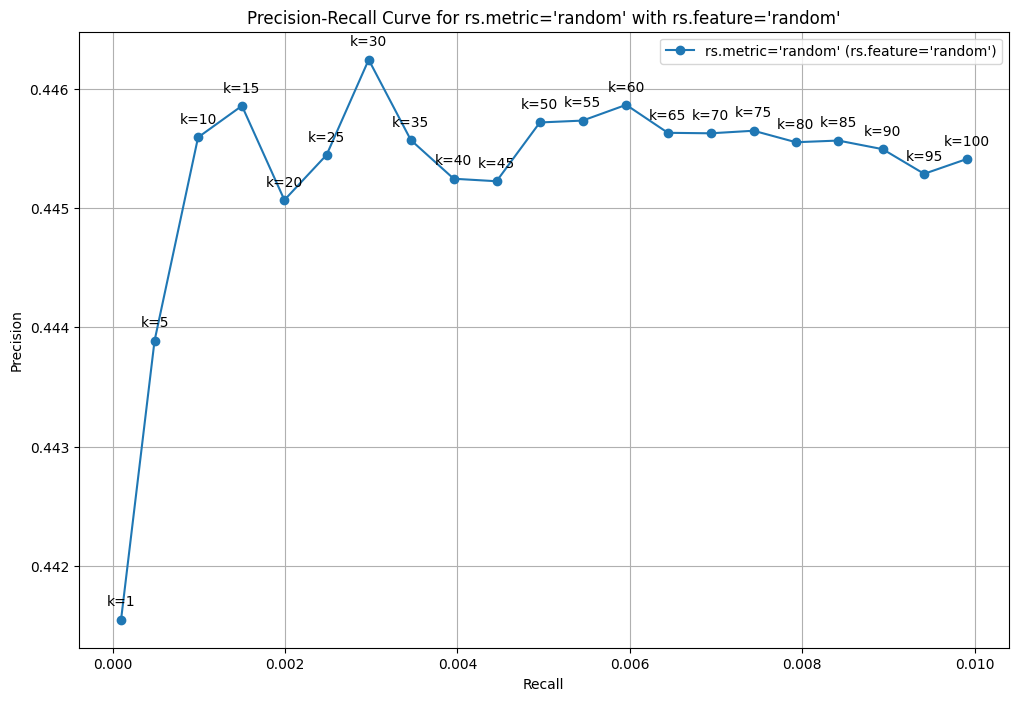

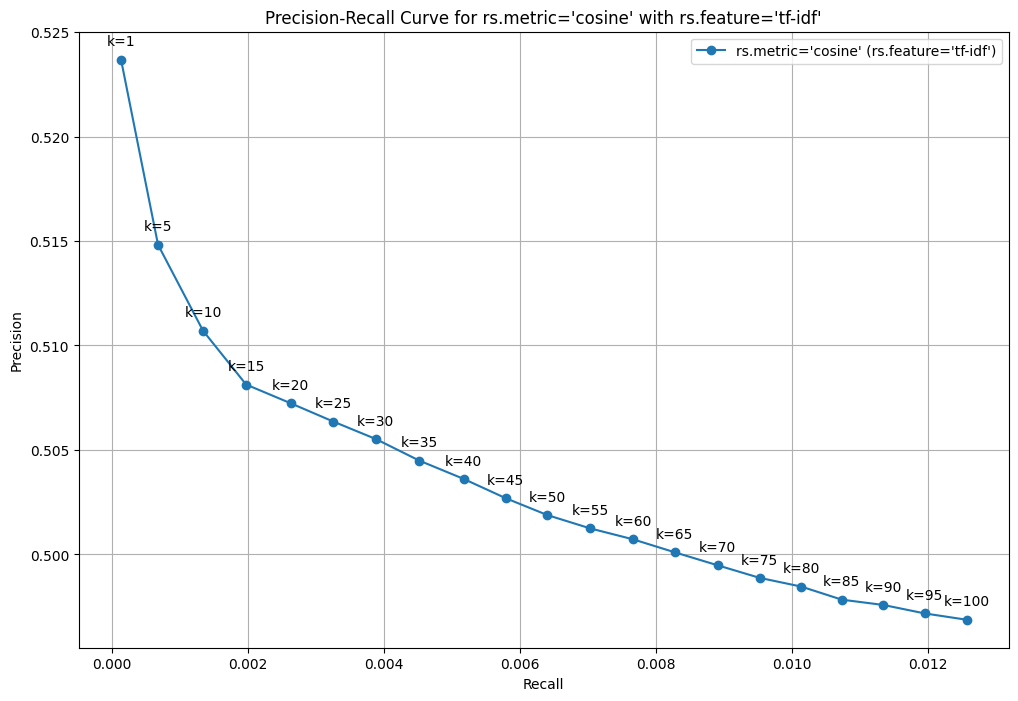

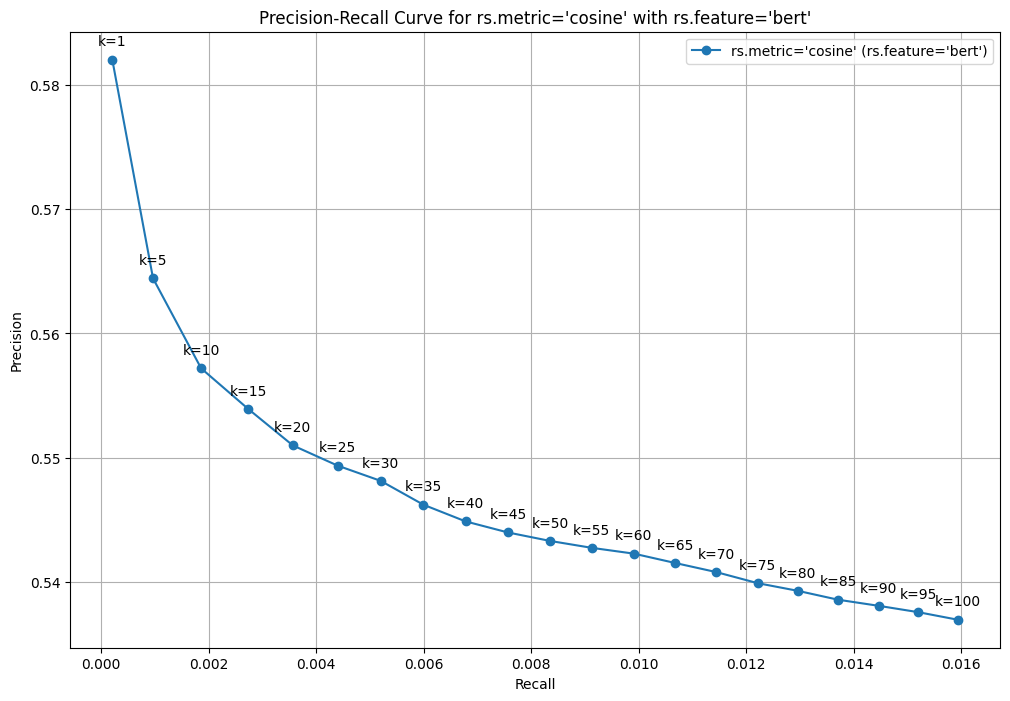

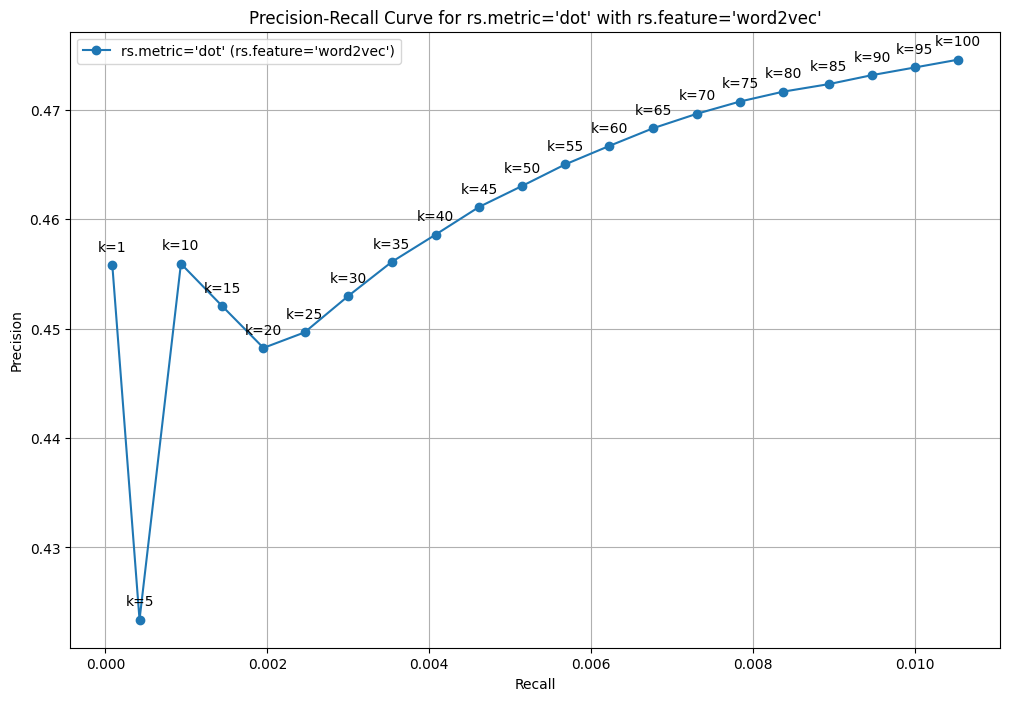

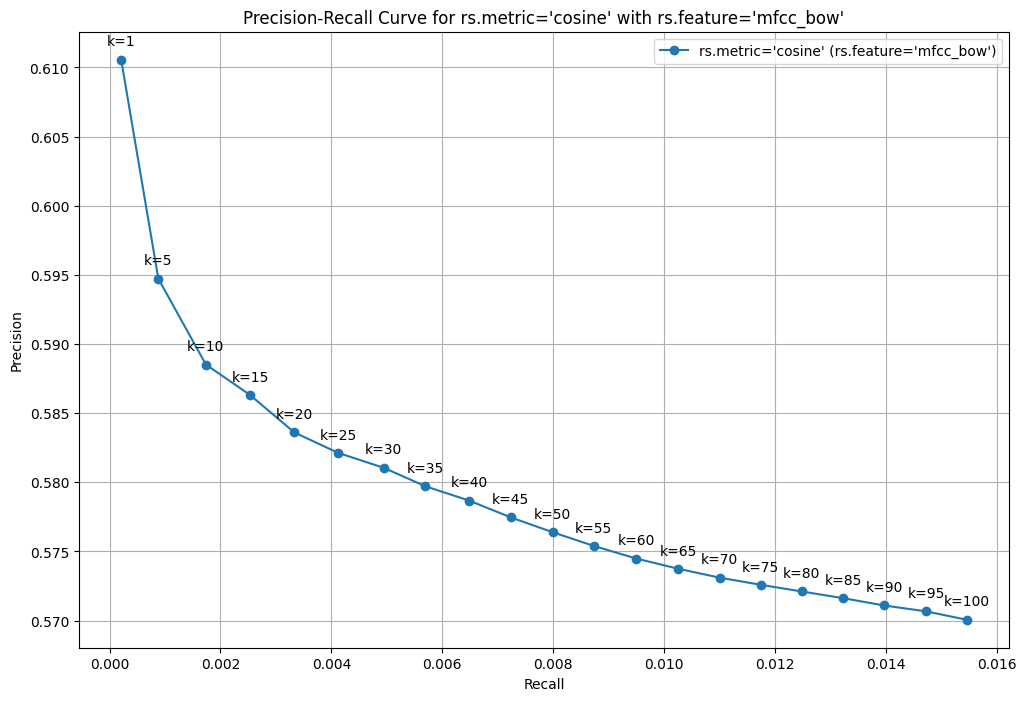

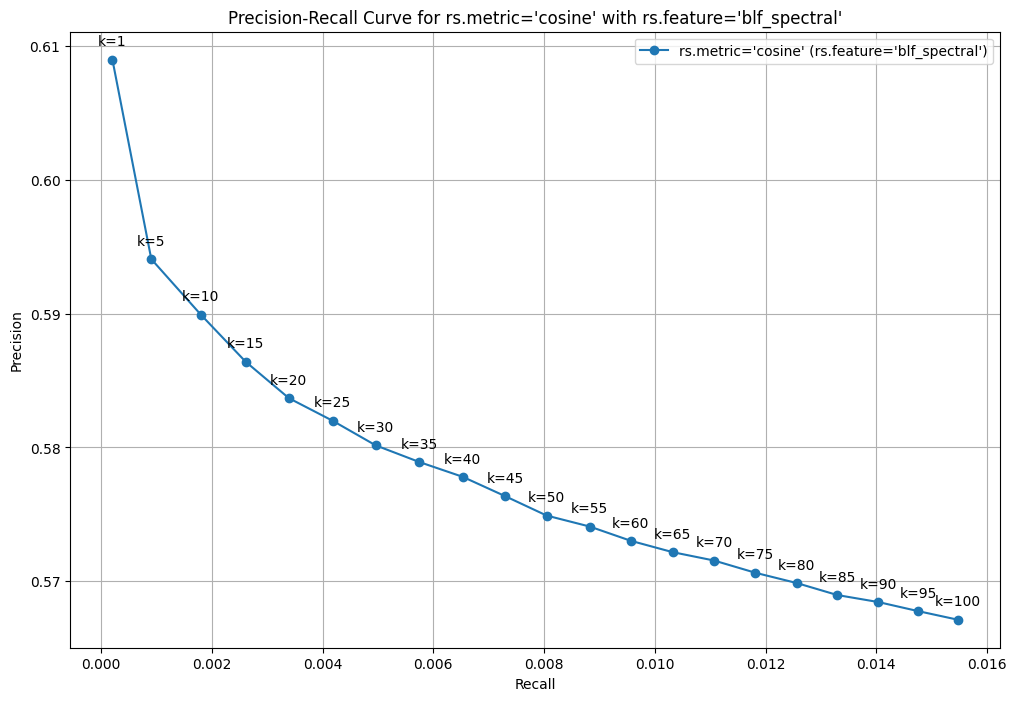

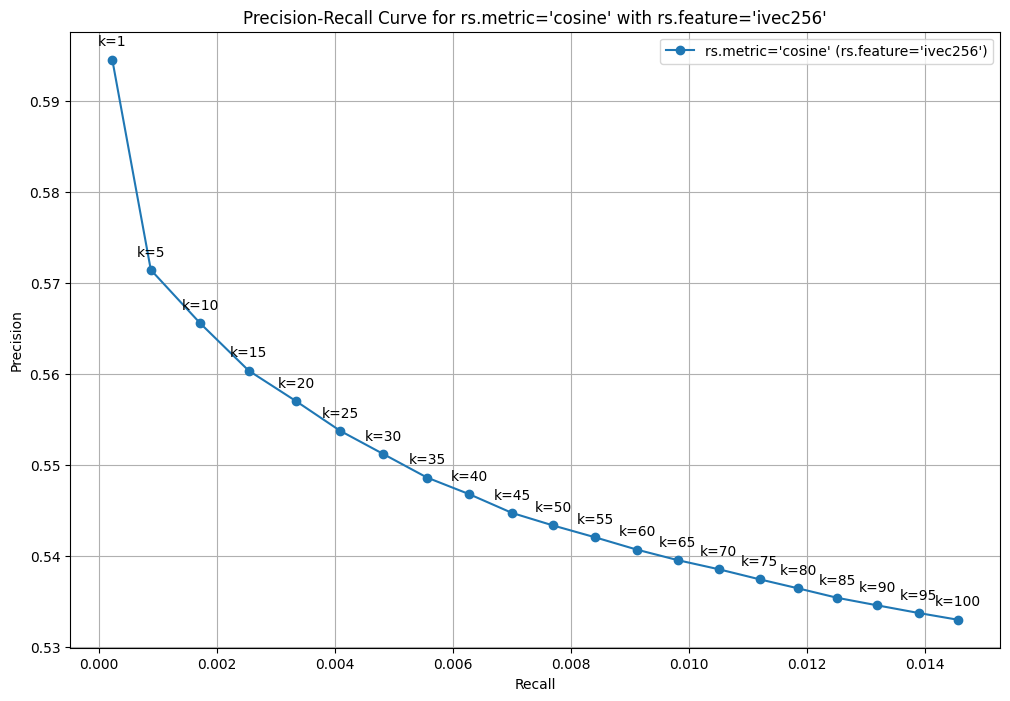

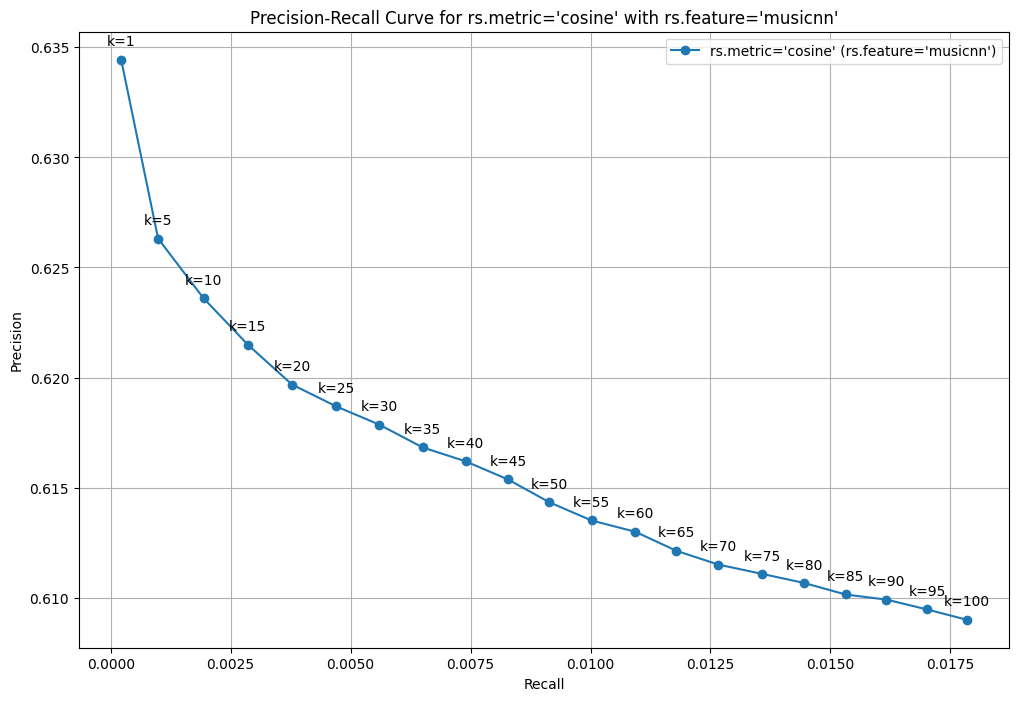

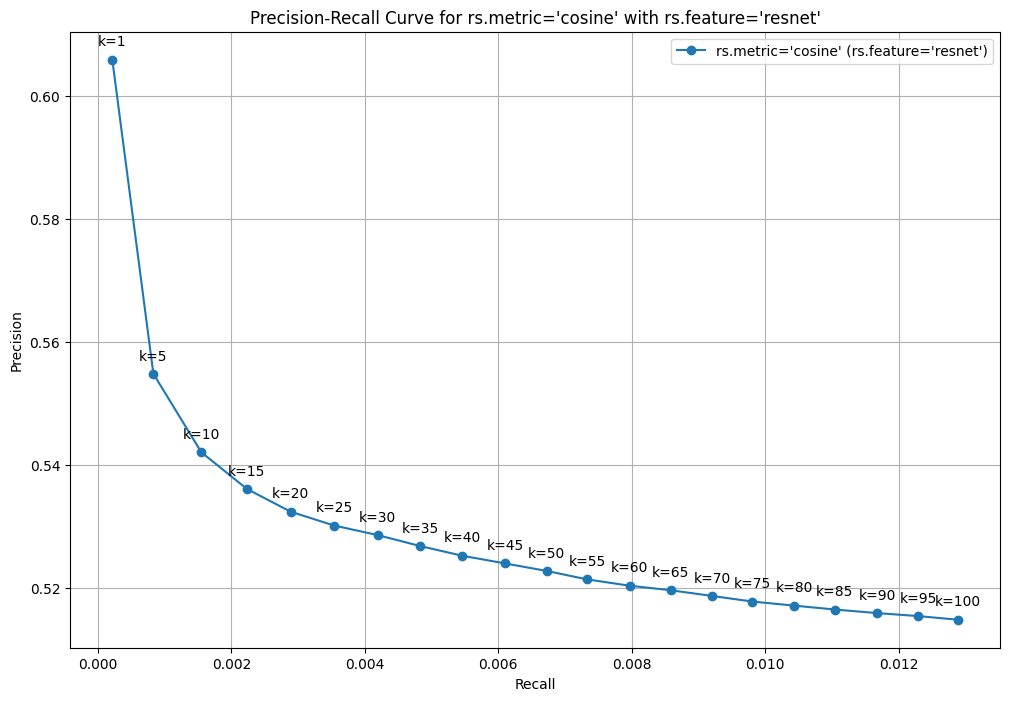

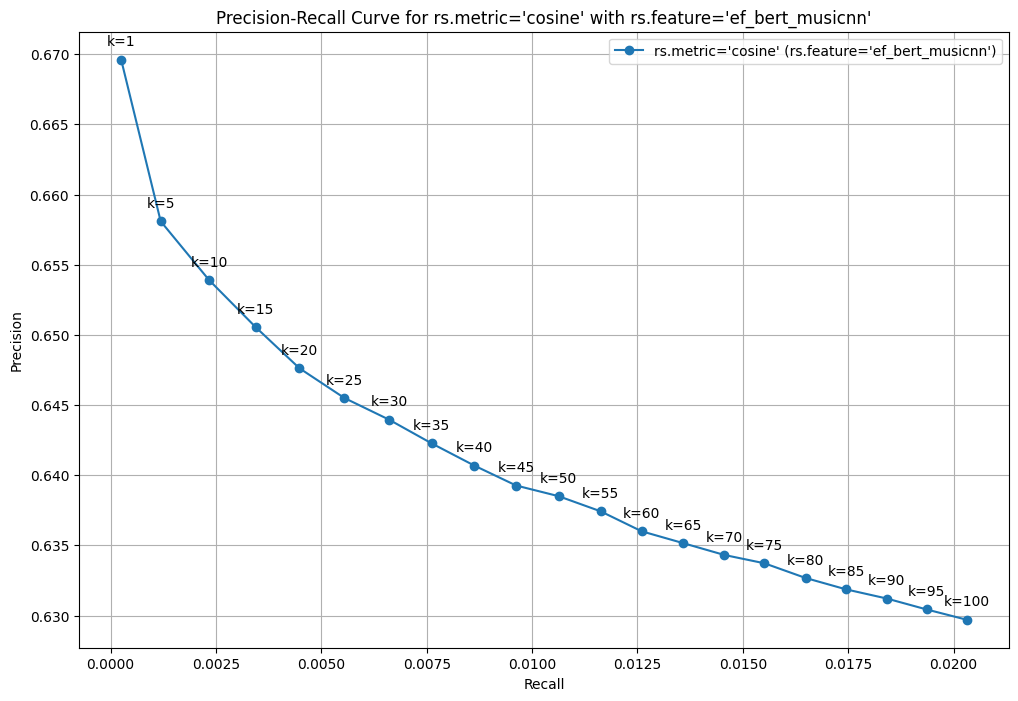

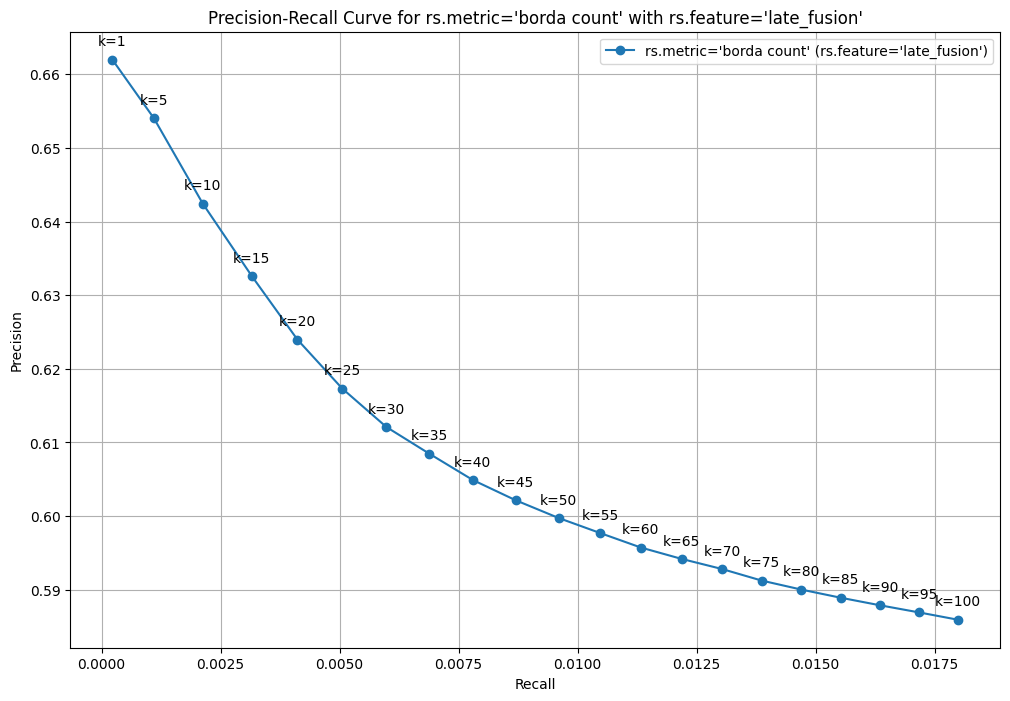

In [33]:
for rs in result.itertuples():
    metrics_df = rs.precision_and_recall_interval
    
    plt.figure(figsize=(12, 8))
    plt.plot(
        metrics_df["recall"],
        metrics_df["precision"],
        marker="o",
        label=f"{rs.metric=} ({rs.feature=})",
    )

    # Annotate each point with its k value
    for k, recall, precision in zip(
        metrics_df.index, metrics_df["recall"], metrics_df["precision"]
    ):
        plt.annotate(
            f"k={k}",
            (recall, precision),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
        )

    plt.title(f"Precision-Recall Curve for {rs.metric=} with {rs.feature=}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()